## Time Series Use Case

Case from IVOA Data Model Workshop, May 2021.

This case involves Time Series data from different providers, each with very different internal structure, annotated to the IVOA data models (Dataset, NDCube, Meas, Coords).

Thread:
  * Using the same simple script, extract and plot the contained TimeSeries data.


### Setup

In [1]:
import sys
from rama.reader import Reader
from rama.reader.votable import Votable
from rama.models.cube import SparseCube
from rama.models.measurements import Symmetrical

from matplotlib import pyplot as plt

sys.path.append('../utils')
from printutils import *


In [2]:
# Subroutine to load file and extract TimeSeries data.

def load_data( infile ):
    
    # Read the file
    doc = Reader( Votable( infile ) )
    
    # Extract instance(s) of SpaceCube (aka: TimeSeries)
    cubes = doc.find_instances(SparseCube)[0]  # packed 

    # Separate the TimeSeries for each source

    # minor hack here.. covers for a bug in rama with propogating cardinality in packed form.
    if isinstance(cubes.data, list) and isinstance(cubes.data[0], list):
        cubes.cardinality = len(cubes.data[0])
        ts = cubes.unroll()
    else:
        ts = [cubes]

    return ts

In [3]:
# Subroutine prints a short summary of the input TimeSeries content.

def ts_summary( ts ):

    for instance in ts:
        print("Instance: {}".format( get_type_name( instance )))
        print("  o Data Product Type: {}".format( instance.dataset.data_product_type) )
        print("  o Data Product SubType: {}".format( instance.dataset.data_product_subtype) )
        print("  o Target Name: {}".format( instance.dataset.target.name) )
        
        # Identify data axes
        print("  o Axes:")
        print("      o Independent Axis: {}".format( str( instance.data[0].independent )))
        print("      o Dependent Axes: {}".format(str( instance.data[0].dependent )))

        # How many data points?
        print("  o Number Points: {}".format( len( instance.data )))
        
        print("")



In [4]:
# Subroutine to generate a simple plot of TimeSeries/Cube data

def plot_cubes( cubes, xaxis, yaxis, plotfile ):

    fig = plt.figure(figsize=[8.0,4.8])
    ax = fig.add_subplot(111)
    ax.grid(True)
    ax.set_title("Cube Data Points")

    first = True
    for cube in cubes:
        # Setup plot from first cube
        if first:
            label = xaxis
            if hasattr( cube.data[0][xaxis].measure, 'unit'):
                label += " ({})".format(cube.data[0][xaxis].measure.unit)
            ax.set_xlabel(label)
                
            label = yaxis
            if hasattr( cube.data[0][yaxis].measure, 'unit'):
                label += " ({})".format(cube.data[0][yaxis].measure.unit)
            ax.set_ylabel(label)
    
        first = False

        tag = "source: "+cube.dataset.target.name+", band: "+cube.data[0][yaxis]._axis.measure.coord.coord_sys.frame.name
        
        # Gather data and add to plot
        points = [ instance for instance in cube.data if instance is not None ]
        xvals = [ point[xaxis].measure.value for point in points ]
        yvals = [ point[yaxis].measure.value for point in points ]
        if isinstance( points[0][yaxis].stat_error, Symmetrical ):
            yerr = [ point[yaxis].stat_error.radius.value for point in points ]
        else:
            yerr = None

        ax.errorbar( xvals, yvals, yerr=yerr, fmt=".-", ecolor='#000000', label=tag )

    plt.legend()

    if plotfile is not None:
        plt.savefig( plotfile )
    

### Summarize sample datasets

In [5]:
## open annotated datasets and extract TimeSeries instances

print("========== GAVO Sample File ==========")
ts_gavo = load_data( "./data/ts.avot")
ts_summary( ts_gavo )

print("")
print("========== ZTF Sample File ==========")
ts_ztf  = load_data( "./data/TimeSeriesZTF.avot")
ts_summary( ts_ztf )

print("")
print("========== GAIA Sample File ==========")
ts_gaia = load_data( "./data/gaia_multiband.avot")
ts_summary( ts_gaia )


========== GAVO Sample File ==========


Can't apply adapter: Longitude instances require units equivalent to 'rad', so cannot set it to ''.


Instance: rama.models.cube.SparseCube
  o Data Product Type: TIMESERIES
  o Data Product SubType: lightcurve
  o Target Name: 1866721434011386240
  o Axes:
      o Independent Axis: ['time']
      o Dependent Axes: ['magnitude', 'generic']
  o Number Points: 38


========== ZTF Sample File ==========
Instance: rama.models.cube.SparseCube
  o Data Product Type: TIMESERIES
  o Data Product SubType: lightcurve
  o Target Name: 686103400034440
  o Axes:
      o Independent Axis: ['time']
      o Dependent Axes: ['magnitude', 'position']
  o Number Points: 150

Instance: rama.models.cube.SparseCube
  o Data Product Type: TIMESERIES
  o Data Product SubType: lightcurve
  o Target Name: 686103400106565
  o Axes:
      o Independent Axis: ['time']
      o Dependent Axes: ['magnitude', 'position']
  o Number Points: 150


========== GAIA Sample File ==========
Instance: rama.models.cube.SparseCube
  o Data Product Type: TIMESERIES
  o Data Product SubType: GAIA Time Series
  o Target Name: 5813

### Plot sample datasets

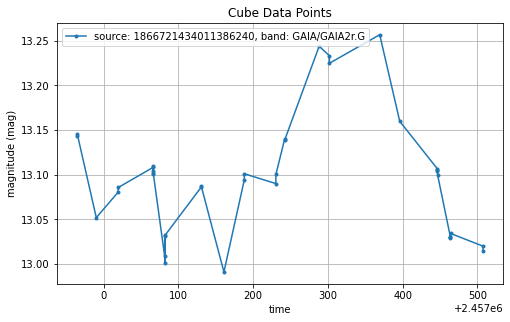

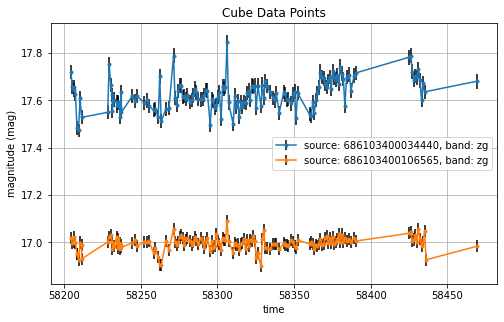

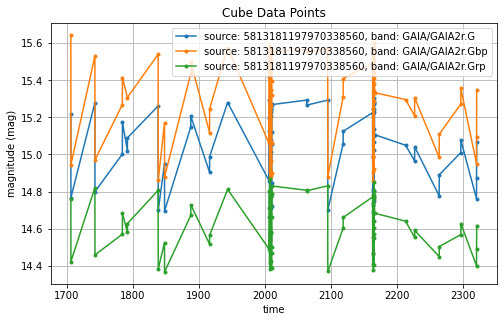

In [6]:
# GAVO Sample File
plot_cubes( ts_gavo, "time", "magnitude", "./temp/gavo_timeseries.png")

# ZTF Sample File
plot_cubes( ts_ztf, "time", "magnitude", "./temp/ztf_timeseries.png")

# GAIA Sample File
plot_cubes( ts_gaia, "time", "magnitude", "./temp/gaia_timeseries.png")
